In [1]:
import os
import copy
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import sys
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
# from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
from PIL import Image
warnings.filterwarnings("ignore")

In [2]:
class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            path, target = self.samples[index]
            sample = self.loader(path)
            if self.transform is not None:
                sample = self.transform(sample)
            if self.target_transform is not None:
                target = self.target_transform(target)
            return sample, target
        except Exception as e:
            print(f"Skipping a problematic sample at index {index}, error: {e}")
            return torch.zeros([3, 224, 224]), -1  # Return dummy tensor and a dummy label

In [3]:
# Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Define the robust dataset
entire_dataset = RobustImageFolder(root='./data/wikiart_sample_large/', transform=transform)

# Now, you can calculate the lengths for splitting
total_size = len(entire_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# Perform the split
train_dataset, val_dataset = random_split(entire_dataset, [train_size, val_size])

# Now, you can create your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) #batch_size
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [5]:
class CustomResNet50(nn.Module):
    def __init__(self, dropout_rate=0.5,num_classes=27): #dropout_rate=0.5
        super(CustomResNet50, self).__init__()
        # Load the pre-trained ResNet-50 model
        self.resnet50_model = models.resnet50(pretrained=True)
        self.dropout = nn.Dropout(dropout_rate)

        # Modify its classifier to fit our number of classes
        num_ftrs = self.resnet50_model.fc.in_features
        self.resnet50_model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet50_model(x)
        x = self.dropout(x)
        return x

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
model = CustomResNet50()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) # learning rate
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
print(f"Using device: {device}")

Using device: cuda


In [10]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 2
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        if inputs is None or labels is None or -1 in labels:
            print(f"Skipping a problematic batch at index {i}")
            continue

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        sys.stdout.write(f"\r[Epoch {epoch+1}, Mini-batch {i+1}] loss: {loss.item()}")
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)
    
    print(f"\nEpoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}\n")
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            if inputs is None or labels is None or -1 in labels:
                print(f"Skipping a problematic batch in validation set")
                continue
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    actual_accuracy = 100 * correct_val / total_val
    val_accuracies.append(actual_accuracy)
    
    print(f'Validation accuracy after epoch {epoch+1}: {actual_accuracy:.2f}%')
    
    if actual_accuracy > best_accuracy:
        best_accuracy = actual_accuracy
        torch.save(model, "wiki_TL_resnet_model_exp_large.pth")
        print(f"Best model saved with accuracy: {best_accuracy:.2f}%")
        
print("Training finished.")
print(f"Best model saved with accuracy: {best_accuracy:.2f}%")

[Epoch 1, Mini-batch 427] loss: 2.581216335296631Skipping a problematic sample at index 7228, error: broken data stream when reading image file
Skipping a problematic batch at index 427
[Epoch 1, Mini-batch 469] loss: 2.8542766571044923
Epoch 1/2, Loss: 2.8008465416141664

Validation accuracy after epoch 1: 37.53%
Best model saved with accuracy: 37.53%
[Epoch 2, Mini-batch 125] loss: 2.69553542137146Skipping a problematic sample at index 7228, error: broken data stream when reading image file
Skipping a problematic batch at index 125
[Epoch 2, Mini-batch 469] loss: 3.2565221786499023
Epoch 2/2, Loss: 2.5233407833937136

Validation accuracy after epoch 2: 42.66%
Best model saved with accuracy: 42.66%
Training finished.
Best model saved with accuracy: 42.66%


In [11]:
# Calculate the most frequent label in the training set
label_counts = Counter([label for _, label in train_dataset])
most_common_label, frequency = label_counts.most_common(1)[0]

# Calculate the expected accuracy if no model (always predicting the most frequent label)
baseline_accuracy = (frequency / len(train_dataset)) * 100
print(f"Expected accuracy if no model: {baseline_accuracy:.2f}%")

Skipping a problematic sample at index 7228, error: broken data stream when reading image file
Expected accuracy if no model: 4.43%


In [12]:
label_to_style = {
    0: 'Abstract',
    1: 'Baroque',
    2: 'Cubism',
    3: 'Expressionism',
    4: 'Fauvism',
    5: 'Impressionism',
    6: 'Pop Art',
    7: 'Realism',
    8: 'Renaissance',
    9: 'Romanticism',
    10: 'Surrealism',
    11: 'Symbolism',
    12: 'Art Nouveau',
    13: 'Art Deco',
    14: 'Gothic',
    15: 'Neoclassicism',
    16: 'Post-Impressionism',
    17: 'Minimalism',
    18: 'Rococo',
    19: 'Byzantine',
    20: 'Contemporary',
    21: 'Photorealism',
    22: 'Pointillism',
    23: 'Futurism',
    24: 'Suprematism',
    25: 'Constructivism',
    26: 'Naive Art'
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

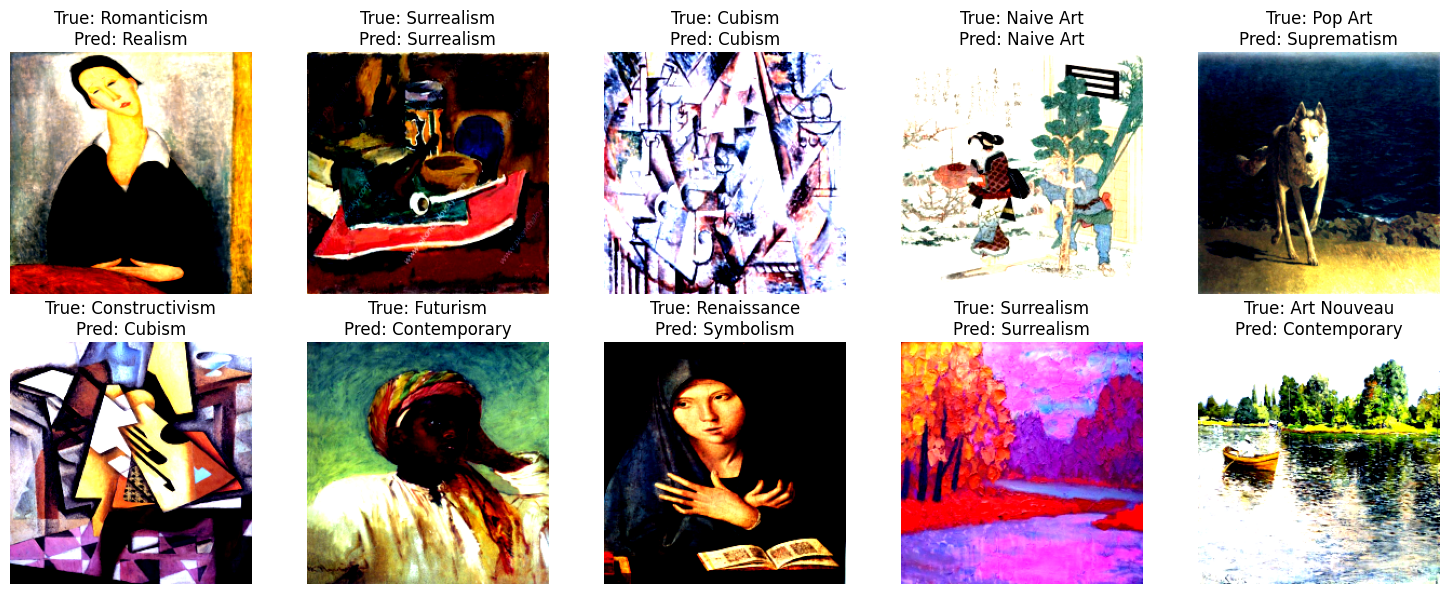

In [14]:
def imshow(img):
    img = img.cpu() / 2 + 0.5  # unnormalize and move to CPU
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# next(dataiter)
# Move the iterator and model to the same device (assuming model is on GPU)
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to('cuda'), labels.to('cuda')

# Get the model output
model.eval()
outputs= model(images[:10])
_, predicted = torch.max(outputs.data, 1)

# Move images and labels back to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Show images with true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # Adjusted for a 2x5 grid

for i in range(10):  # Loop 10 times for 10 images
    row = i // 5
    col = i % 5
    img = images[i] / 2 + 0.5  # unnormalize
    img = img.numpy()
    axs[row, col].imshow(np.transpose(img, (1, 2, 0)))

    true_label = label_to_style[int(labels[i].item())]  # Make sure label_to_style is defined
    predicted_label = label_to_style[int(predicted[i].item())]

    axs[row, col].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
all_labels = []
all_preds = []
model.eval()

with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the same device as the model (assuming it's on GPU)
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        outputs = model(inputs[:10])
        predicted_labels = labels[:10]
        _, predicted = torch.max(outputs.data, 1)

        # Move predicted_labels and predicted back to CPU for further processing
        predicted_labels = predicted_labels.cpu()
        predicted = predicted.cpu()

        all_labels.extend(predicted_labels)
        all_preds.extend(predicted)

# Convert to Python integers
all_labels = [label.item() for label in all_labels]
all_preds = [pred.item() for pred in all_preds]

# Calculate the confusion matrix
print("Confusion Matrix:")
conf_mat = confusion_matrix(all_labels, all_preds)

In [ ]:
# print("Classification Report:")
# print(classification_report(all_labels, all_preds))

In [ ]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=sorted(list(label_to_style.values()))))

In [ ]:
unique_styles = sorted(list(label_to_style.values()))

plt.figure(figsize=(12, 9))
sns.heatmap(conf_mat, fmt='d', cmap='Blues',
            xticklabels=unique_styles,
            yticklabels=unique_styles)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Plotting
plt.figure(figsize=(12, 5))

# Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Train and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

class CustomResNet50(nn.Module):
    def __init__(self, dropout_rate=0.5, num_classes=27):
        super(CustomResNet50, self).__init__()
        self.resnet50_model = models.resnet50(pretrained=True)
        self.dropout = nn.Dropout(dropout_rate)
        num_ftrs = self.resnet50_model.fc.in_features
        self.resnet50_model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet50_model(x)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.handlers = []

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.feature = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()
        
        self.handlers.append(self.target_layer.register_forward_hook(forward_hook))
        self.handlers.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handler in self.handlers:
            handler.remove()

    def __call__(self, x, target_class=None):
        self.register_hooks()

        output = self.model(x)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        score = output[:, target_class]
        self.model.zero_grad()
        score.backward(torch.ones_like(score))

        # Compute the CAM
        weights = F.adaptive_avg_pool2d(self.gradient, (1, 1))
        cam = (weights * self.feature).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= cam.max()

        self.remove_hooks()
        
        return cam
    

    def visualize(self, cam, input_image):
        input_image = input_image.squeeze().cpu().detach().numpy().transpose((1, 2, 0))

        # Process cam
        cam = F.interpolate(cam, size=input_image.shape[:2], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        heatmap = plt.get_cmap("jet")(cam)[:,:,:3]

        # Higher figsize and dpi for better resolution, 1 row and 2 columns for side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=40)

        axes[0].imshow(input_image)  # Now using processed input_image
        axes[0].axis('off')
        axes[0].set_title('Original Image')

        axes[1].imshow(heatmap)
        axes[1].axis('off')
        axes[1].set_title('Grad-CAM')

        plt.tight_layout()  # Adjusts subplot params for better layout
        plt.show()

# Initialize your CustomResNet50 and GradCAM
model = CustomResNet50().to(device)
target_layer = model.resnet50_model.layer4[2]  # The last convolutional layer in ResNet50

grad_cam = GradCAM(model, target_layer)


# input_image = input_image.unsqueeze(0).to(device)

# Load the image
image_path = "data/wikiart_sample/Contemporary_Realism/eric-fischl_portrait-of-a-couple-steve-and-anne-in-la.jpg"  # Change this to the path of the image you want to test
input_image = Image.open(image_path).convert('RGB')
input_image = transform(input_image)

input_image = input_image.view(1, 3, 224, 224).to(device)
print(input_image.shape)

output = model(input_image)
target_class = output.argmax(dim=1).item()


cam = grad_cam(input_image, target_class)

# Visualize
grad_cam.visualize(cam, input_image)
